## Imports

In [1]:
import numpy as np
import pickle
import os
from MyDataset import MyDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
# from PIL import Image
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
%matplotlib inline

## Transform raw data

In [2]:
pre_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomCrop(200),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean = [0.5317,0.5026,0.5184,0.5190],std = [0.2617,0.2877,0.2941,0.2958]),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean = [0.5317,0.5026,0.5184,0.5190],std = [0.2617,0.2877,0.2941,0.2958]),
    transforms.ToTensor()
])

## Load Data

In [3]:
train_dataset = MyDataset("./train",pre_transform)
val_dataset = MyDataset("./validate",val_transform)

In [4]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


## Visualize Traning Data

In [44]:
#Calculate the number of samples in differnet class
train_nil_count = 0   ##591
train_MOD_count = 0   ##839
train_SEV_count = 0   ##324
valid_nil_count = 0   ##192
valid_MOD_count = 0   ##81
valid_SEV_count = 0   ##33
data0 = []
data1 = []
data2 = []
data3 = []

for i in range (0,1754):
    #print(i)
    img, label = train_dataset[i]
    if (label == 0):
        train_nil_count += 1
        data0.append(img[0,:,:].numpy())
        data1.append(img[1,:,:].numpy())
        data2.append(img[2,:,:].numpy())
        data3.append(img[3,:,:].numpy())
    elif (label == 1):
        train_MOD_count += 1
        data0.append(img[0,:,:].numpy())
        data1.append(img[1,:,:].numpy())
        data2.append(img[2,:,:].numpy())
        data3.append(img[3,:,:].numpy())
    else:
        train_SEV_count += 1
        data0.append(img[0,:,:].numpy())
        data1.append(img[1,:,:].numpy())
        data2.append(img[2,:,:].numpy())
        data3.append(img[3,:,:].numpy())
# print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))
data0 = torch.Tensor(data0)
data1 = torch.Tensor(data1)
data2 = torch.Tensor(data2)
data3 = torch.Tensor(data3)
print(torch.mean(data0), torch.std(data0))
print(torch.mean(data1), torch.std(data1))
print(torch.mean(data2), torch.std(data2))
print(torch.mean(data3), torch.std(data3))
# for i in range (0,306):
#     #print(i)
#     img, label = val_dataset[i]
#     if (label == 0):
#         valid_nil_count += 1
#     elif (label == 1):
#         valid_MOD_count += 1
#     else:
#         valid_SEV_count += 1
# print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

tensor(0.5317) tensor(0.2617)
tensor(0.5026) tensor(0.2877)
tensor(0.5184) tensor(0.2941)
tensor(0.5190) tensor(0.2958)


In [5]:
list(resnet18.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

## Define Model & Loss

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1  = nn.Conv2d(4, 3, 3, 1, 1)
        self.bn = nn.BatchNorm2d(3)
        self.extractor = nn.Sequential(*list(resnet18.children())[:-2]).cuda()
        for param in list(self.extractor.parameters()):
            param.requires_grad = False
        
        self.conv3 = nn.Conv2d(512,512,3,1,1)
        
        self.fc1 = nn.Linear(4608, 128)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.extractor(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #x = F.relu(x)
        #output = F.softmax(x, dim=1)
        return x

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

In [7]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 6

In [31]:
for param in list(model.parameters()):
    if(param.requires_grad == True):
        print(param)

Parameter containing:
tensor([[[[ 0.1142,  0.1326, -0.0717],
          [ 0.1366, -0.0746,  0.1468],
          [ 0.0350, -0.0177,  0.0857]],

         [[-0.0311, -0.0241, -0.0331],
          [-0.1410,  0.1151, -0.0688],
          [ 0.1520,  0.1110,  0.0394]],

         [[-0.1446,  0.0008,  0.1141],
          [-0.0282,  0.1605, -0.1260],
          [-0.0076, -0.0824,  0.0051]],

         [[ 0.1333,  0.1030, -0.1565],
          [ 0.0942, -0.0863, -0.0346],
          [ 0.1514, -0.0193, -0.1605]]],


        [[[ 0.1620, -0.0949,  0.0730],
          [ 0.0598,  0.1555,  0.1646],
          [-0.0886, -0.0005, -0.0310]],

         [[-0.0124, -0.1331,  0.0090],
          [ 0.0006, -0.1298,  0.0321],
          [ 0.0926,  0.0675,  0.0179]],

         [[-0.1198, -0.1194,  0.0807],
          [ 0.0664, -0.1171, -0.0636],
          [-0.1131, -0.0069, -0.0622]],

         [[ 0.0755, -0.1205,  0.1654],
          [-0.0928, -0.1581, -0.0940],
          [ 0.1609, -0.0143,  0.0594]]],


        [[[ 0.0641, -0

## LDAM Loss

In [8]:
class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

In [9]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
    loss = 0
    n_class = [n_class_nil, n_class_MOD, n_class_SEV]
    #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
    niter = output.shape[0] # 64 for a batch
    for i in range(niter):
        Z_y = output[i][target[i]]
        delta_y = C / (n_class[target[i]] ** (0.25) )
        nominator = torch.exp(Z_y - delta_y)
        if (target[i] == 0):
            dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
        elif (target[i] == 1):
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
        else:
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
        loss += (-torch.log(nominator/dinominator))
    return loss

In [10]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [11]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [12]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [13]:
model = model.cuda()
#criterion = criterion.cuda()

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [15]:
def train_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        loss = LDAMLoss(outputs,targets,591,839,324,C = 1.0)
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs

In [16]:
def validate_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,192,81,33,C = 1)

        #loss.backward()
        #optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs  

In [17]:
best_epoch = -1
best_acc = 0.0
best_model_state = model.state_dict()
history_train_acc = []
history_val_acc = []
n_epoch = 50

for epoch in tqdm(range(n_epoch)):
    for phase in range (0,2):
        if phase == 0:
            model.train()
            accs = train_one_epoch()
            print("epoch {} train acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_train_acc.append(accs)
            scheduler.step()
            
        elif phase == 1:
            model.eval()
            accs = validate_one_epoch()
            print("epoch {} valid acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_val_acc.append(accs)
            
            if accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()   
            
print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')

TypeError: tensor should be a torch tensor. Got <class 'PIL.Image.Image'>.

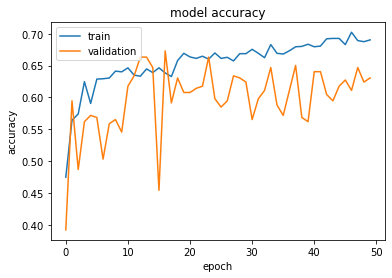

In [18]:
train_accuracy = []
val_accuracy = []
for accs in history_train_acc:
    train_accuracy.append(accs.avg)
for accs in history_val_acc:
    val_accuracy.append(accs.avg)
plt.plot(range(n_epoch),train_accuracy)
plt.plot(range(n_epoch),val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [19]:
torch.save(best_model_state, "resnet_state_50_batchnorm.pt")

In [20]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print("y actual:",y)
    print(outputs.argmax(dim=1, keepdim=True).view(-1))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

y actual: tensor([0, 1, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0,
        1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 0, 0])
tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 2,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
Test Acc: 0.59375
y actual: tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0,
        2, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Test Acc: 0.703125
y actual: tensor([0, 0, 0, 0, 1, 2, 1, 0,

In [36]:
img, label = train_dataset.__getitem__(1700)

In [37]:
img.shape

torch.Size([4, 224, 224])

In [39]:
img[0,:,:].sum().

tensor(30768.3457)

In [26]:
img = torch.tensor(color_img)
img = img.permute(1,2,0)
img = img/255
img.shape

torch.Size([224, 224, 4])

TypeError: Invalid shape (224, 4, 224) for image data

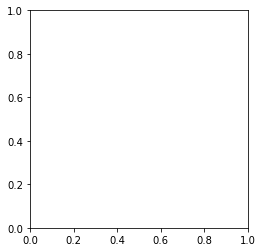

In [27]:
plt.imshow(img.permute(1,2,0))

In [25]:
a = torch.Tensor([[1,2],[2,3]])
a[:,0]

tensor([1., 2.])